<a href="https://colab.research.google.com/github/mdsalem17/scientific-guide-notebooks/blob/main/fashion_mnist/fashion_mnist_interpretability.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Model Selection, Analysis, Interpretability on Fashion MNIST with scikit-learn and TensorFlow
---
In this notebook, we will explore and visualize the Fashion MNIST dataset. Then, we will perform Permutation Feature Importance using scikit-learn. Finally, we will be working with SHAP (SHapley Additive exPlanations). In particular:

1. Data Exploration and Visualization
  * Exploring Fashion MNIST
  * Visualization using PCA
1. Permutation Feature Importance
  * Train a Random Forest classifier on the data as baseline.
  * Compute the feature importance score by permutating each feature.
  * Re-train the model with only the top features.
  * Check other classifiers for comparison.
2. Explaining the outputs with SHapley Additive exPlanations
  * Train a simple CNN on the fashion mnist dataset.
  * Compute the Shapley values for examples of each class.
  * Visualize these values and derive information from them.

Let's get started!

## Imports, inspect and pre-process the data

Begin by installing the shap library, upgrading scikit-learn to the latest version:

In [ ]:
!pip install -q -U scikit-learn
!pip install -q -U shap
!pip install -q tensorflow==2.4.3

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Data Visualization
For our analysis, we will be using Fashion-MNIST dataset of Zalando's article images—consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes. Here’s an example how the data looks (each class takes three-rows): 

![Fashion MNIST examples](https://github.com/zalandoresearch/fashion-mnist/raw/master/doc/img/fashion-mnist-sprite.png)



Now import all necessary dependencies:

In [ ]:
import shap
import tensorflow as tf
from tensorflow import keras

### Data Exploration

For this lab we will use the [fashion MNIST](https://keras.io/api/datasets/fashion_mnist/) dataset from keras. Load it and pre-process the data before feeding it into the model:


In [ ]:
# Download the dataset
(X_train, y_train), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()

We will display the first 30 images of the data frame. The mapping between the numeric value in the label column and the category is defined as follows:

0 - T-shirt/top
1 - Trouser
2 - Pullover
3 - Dress
4 - Coat
5 - Sandal
6 - Shirt
7 - Sneaker
8 - Bag
9 - Ankle boot

In [ ]:
label = ['T-shirt', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

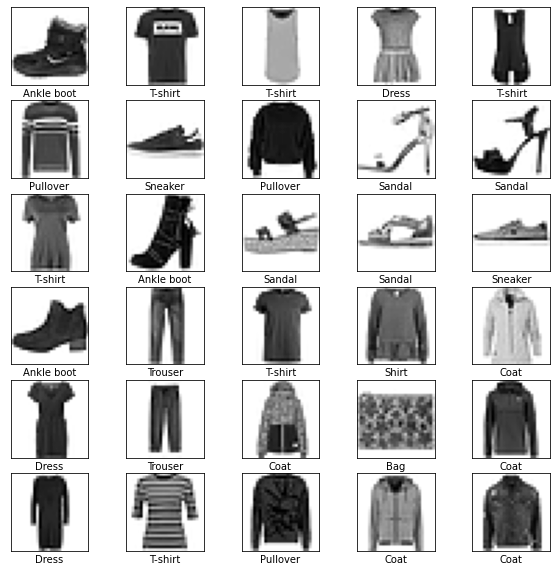

In [ ]:
# Set the figure size
plt.figure(figsize=(10,10))
# Show only the first 30 pictures
for i in range(30):
    plt.subplot(6,5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(np.array(X_train[i, :]).reshape(28,28), cmap=plt.cm.binary)
    plt.xlabel(label[y_train[i]])

### Visualization using Principal Component Analysis
Principal Component Analysis (PCA) is a statistical procedure for reducing the number of dimensions in a dataset whilst retaining most information. It is extensionally used for dimension reduction, especially for high-dimension data.

By calculating and comparing correlations between dimensions, this method provides a minimum number of variables that keep the maximum amount of variation(explanation) about how the original data is distributed. In other words, it skips the dimensions that have less explained variance and keeps the more meaningful ones.

In [ ]:
from __future__ import print_function
import time
from sklearn.decomposition import PCA
from sklearn import decomposition
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

In this notebook we use the Scikit-Learn implementation of PCA to generate two and three dimensional plots from the original 784 dimensions (each pixel is a dimension), so we choose n_components = 3, the first three principal components. Let's see how much variation in the total dataset is explained by these principal components.

In [ ]:
features = ['pixel_' + str(i+1) for i in range(784)]
pca_df = pd.DataFrame(X_train.reshape(X_train.shape[0], X_train.shape[1]*X_train.shape[2]), columns=features)
pca_df['label'] = y_train
pca_df['category']=pca_df['label'].replace([0,1,2,3,4,5,6,7,8,9],label)
pca_df

,pixel_1,pixel_2,pixel_3,pixel_4,pixel_5,pixel_6,pixel_7,pixel_8,pixel_9,pixel_10,pixel_11,pixel_12,pixel_13,pixel_14,pixel_15,pixel_16,pixel_17,pixel_18,pixel_19,pixel_20,pixel_21,pixel_22,pixel_23,pixel_24,pixel_25,pixel_26,pixel_27,pixel_28,pixel_29,pixel_30,pixel_31,pixel_32,pixel_33,pixel_34,pixel_35,pixel_36,pixel_37,pixel_38,pixel_39,pixel_40,...,pixel_747,pixel_748,pixel_749,pixel_750,pixel_751,pixel_752,pixel_753,pixel_754,pixel_755,pixel_756,pixel_757,pixel_758,pixel_759,pixel_760,pixel_761,pixel_762,pixel_763,pixel_764,pixel_765,pixel_766,pixel_767,pixel_768,pixel_769,pixel_770,pixel_771,pixel_772,pixel_773,pixel_774,pixel_775,pixel_776,pixel_777,pixel_778,pixel_779,pixel_780,pixel_781,pixel_782,pixel_783,pixel_784,label,category
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,9,Ankle boot
1,0,0,0,0,0,1,0,0,0,0,41,188,103,54,48,43,87,168,133,16,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,49,136,219,216,228,...,243,214,224,162,0,2,0,0,0,0,0,0,0,0,0,1,0,0,139,146,130,135,135,137,125,124,125,121,119,114,130,76,0,0,0,0,0,0,0,T-shirt
2,0,0,0,0,0,0,0,0,0,22,118,24,0,0,0,0,0,48,88,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,12,100,212,205,...,75,10,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,18,42,57,56,32,8,0,0,1,0,0,0,0,0,0,0,0,T-shirt
3,0,0,0,0,0,0,0,0,33,96,175,156,64,14,54,137,204,194,102,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,73,186,177,183,175,188,...,85,160,133,100,12,0,0,0,0,0,0,0,0,0,0,0,4,0,2,0,35,4,33,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,Dress
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,26,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,189,206,187,32,...,255,70,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,61,102,168,25,0,139,161,74,0,0,0,0,0,0,0,0,0,0,0,T-shirt
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,Sandal
59996,0,0,0,0,0,0,0,0,0,0,15,131,87,95,97,106,95,115,109,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,67,252,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,134,124,0,0,160,80,0,0,0,0,0,0,0,0,0,0,1,Trouser
59997,0,0,0,0,0,0,0,0,0,5,15,0,0,0,0,0,0,39,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,59,225,218,21,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,153,194,206,222,223,209,201,56,0,0,0,0,0,0,0,0,0,0,3,Dress
59998,0,0,0,0,0,0,0,0,0,0,17,191,159,79,85,158,191,23,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,17,65,96,107,77,...,66,51,67,7,0,1,0,0,0,0,0,0,0,0,0,0,11,54,55,61,65,69,67,67,66,63,66,69,66,54,50,5,0,1,0,0,0,0,0,T-shirt


In [ ]:
# Set first three principle components
pca = PCA(n_components=3)
# Fit the model with pixel columns and apply the dimensionality reduction on those columns
pca_result = pca.fit_transform(pca_df[features])

The pca.explained_variance_ratio_ parameter returns a vector of the variance explained by each dimension.

In [ ]:
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal component: [0.29039228 0.1775531  0.06019222]


In [ ]:
pca_df['First Dimension'] = pca_result[:,0]
pca_df['Second Dimension'] = pca_result[:,1] 
pca_df['Third Dimension'] = pca_result[:,2]

Now, let's visualize the first 3 principle vectors in the principle component analysis.

Text(0.5, 0.98, '3-Component PCA')

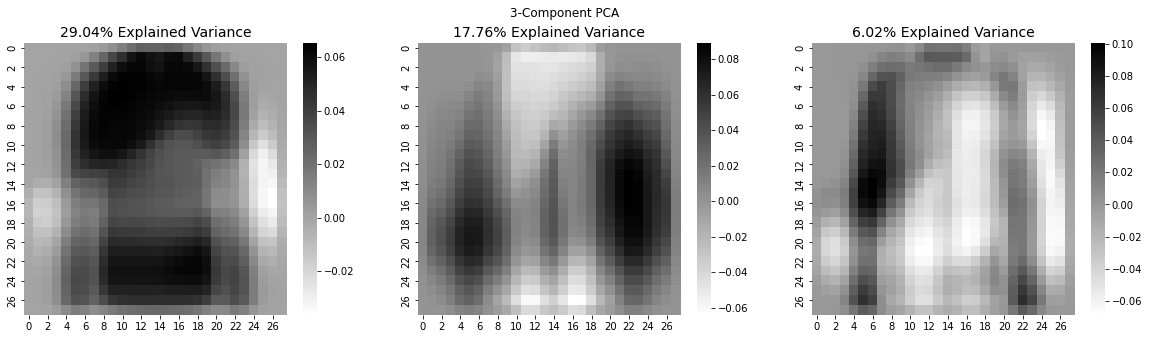

In [ ]:
#Set figure size
fig, axarr = plt.subplots(1, 3, figsize=(20, 5))
# use seaborn heatmap to visualize the first three pca components
sns.heatmap(pca.components_[0, :].reshape(28, 28), ax=axarr[0], cmap=plt.cm.binary)
sns.heatmap(pca.components_[1, :].reshape(28, 28), ax=axarr[1], cmap=plt.cm.binary)
sns.heatmap(pca.components_[2, :].reshape(28, 28), ax=axarr[2], cmap=plt.cm.binary)
# Set picture title to explained variance
axarr[0].set_title(
    "{0:.2f}% Explained Variance".format(pca.explained_variance_ratio_[0]*100), fontsize=14)
axarr[1].set_title(
    "{0:.2f}% Explained Variance".format(pca.explained_variance_ratio_[1]*100), fontsize=14)
axarr[2].set_title(
    "{0:.2f}% Explained Variance".format(pca.explained_variance_ratio_[2]*100), fontsize=14)
# Add picture title
plt.suptitle('3-Component PCA')

Each component is an eigenvector. The first component looks like a T-shirt and a shoe. The second component is a trouser and a pullover. The third component looks like a pullover and an ankle boot.

The first dimension explains 29% of the pixel data, the second dimension explains approximately 17%, while the third dimension explains only 6%. Each additional dimension added to the PCA explains less variance of the data. If the number of component is 784, the cumulative explained variance would be 100%. But reaching 100% explained variance requires too much work, we rather do dimension reduction and sacrifice some explained variance for the sake of efficiency.

It's crucial to pick a relatively small number of components while keep the effectiveness of the model. Let's plot the cumulative explained variance ratio for all components of the principle component analysis. To do this, we can clearly see changes of explained variance with the increase in number of components.

In [ ]:
# initializing the pca
# Set n_components as 784 dimensions
pca = PCA(n_components = 784)
# Fit on training data
pca_784 = pca.fit_transform(pca_df[features])
#percentage_var_explained = pca.explained_variance_ / np.sum(pca.explained_variance_);
var_ratios = np.cumsum(pca.explained_variance_ratio_)

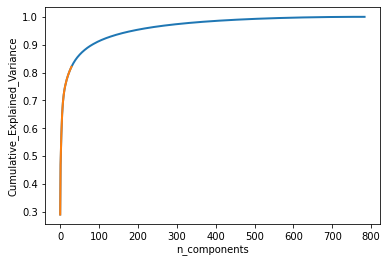

In [ ]:
# Plot the PCA spectrum
plt.figure(figsize=(6, 4))
plt.plot(var_ratios, linewidth=2)
plt.plot(var_ratios[:30], linewidth=2)
plt.xlabel("n_components")
plt.ylabel("Cumulative_Explained_Variance")
plt.show()

From the graph above, we see that 200 components explain approximately 95% variance and 80 components explain 90% variance. As the number of components increase, the explained variance rises to 100%, which makes sense because it is original matrix with 784 dimensions.

Plot the first two dimensions from the pca_df dataframe. Each color represents a label.

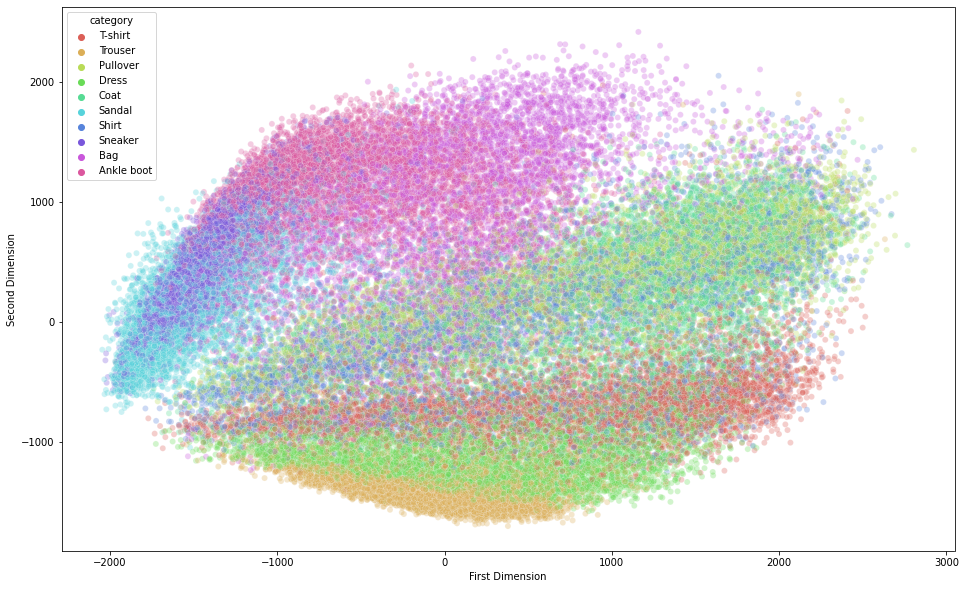

In [ ]:
plt.figure(figsize=(16,10))

sns.scatterplot(
    x="First Dimension", y="Second Dimension",
    hue = "category",
    hue_order = ['T-shirt', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'],
    palette=sns.color_palette("hls", 10),
    data=pca_df,
    legend="full",
    alpha=0.3
)

From the graph above, we can see the two components can separate different categories apart to some degree, but the separation is not clear enough. Let's take a look at the three-dimensional representation.

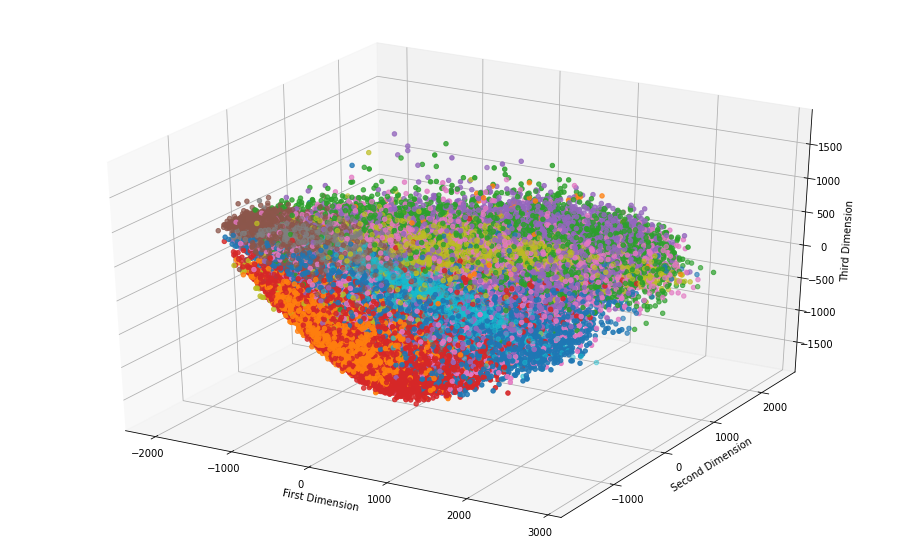

In [ ]:
graph = plt.figure(figsize=(16,10)).gca(projection='3d')
graph.scatter(
    xs=pca_df["First Dimension"], 
    ys=pca_df["Second Dimension"],
    zs=pca_df["Third Dimension"], 
    c=pca_df["label"], 
    cmap='tab10'
)
graph.set_xlabel('First Dimension')
graph.set_ylabel('Second Dimension')
graph.set_zlabel('Third Dimension')
plt.show()

## Permutation Feature Importance


In [ ]:
#(X_train, y_train), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1]*X_train.shape[2])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1]*X_test.shape[2])
X_train.shape, X_test.shape

((60000, 784), (10000, 784))

We will choose 25 features from the original 784.

In [ ]:
index = [776,367,240,145,136,381,747,636,75,491,782,284,536,598,254,167,540,120,294,68,240,178,566,248,100]
X_train = X_train[:,index]
X_test = X_test[:,index]
X_train.shape, X_test.shape

((60000, 25), (10000, 25))

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Instantiate StandardScaler
scaler = StandardScaler()

# Fit it to the train data
scaler.fit(X_train)

# Use it to transform the train and test data
X_train = scaler.transform(X_train)

# Notice that the scaler is trained on the train data to avoid data leakage from the test set
X_test = scaler.transform(X_test)

## Train the classifier

Now we will fit a [Random Forest classifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) with 10 estimators and compute the mean accuracy achieved:

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Fit the classifier
rf_clf = RandomForestClassifier(n_estimators=10, random_state=42).fit(X_train, y_train)

# Print the mean accuracy achieved by the classifier on the test set
rf_clf.score(X_test, y_test)

0.7534

This model achieved a mean accuracy of 75%. Pretty good for a model without fine tunning with far more less features than the original data.

# Permutation Feature Importance

To perform the model inspection technique known as Permutation Feature Importance we will use scikit-learn's built-in function [`permutation_importance`](https://scikit-learn.org/stable/modules/generated/sklearn.inspection.permutation_importance.html#sklearn.inspection.permutation_importance).

We will create a function that given a classifier, features and labels computes the feature importance for every feature:

In [ ]:
from sklearn.inspection import permutation_importance

def feature_importance(clf, X, y, top_limit=None):

  # Retrieve the Bunch object after 50 repeats
  # n_repeats is the number of times that each feature was permuted to compute the final score
  bunch = permutation_importance(clf, X, y,
                                 n_repeats=50, random_state=42)

  # Average feature importance
  imp_means = bunch.importances_mean

  # List that contains the index of each feature in descending order of importance
  ordered_imp_means_args = np.argsort(imp_means)[::-1]

  # If no limit print all features
  if top_limit is None:
    top_limit = len(ordered_imp_means_args)

  # Print relevant information
  for i, _ in zip(ordered_imp_means_args, range(top_limit)):
    name = feature_names[i]
    imp_score = imp_means[i]
    imp_std = bunch.importances_std[i]
    print(f"Feature {name} with index {i} has an average importance score of {imp_score:.3f} +/- {imp_std:.3f}\n")

The importance score is computed in a way that higher values represent better predictive power. To know exactly how it is computed check out this [link](https://scikit-learn.org/stable/modules/permutation_importance.html#outline-of-the-permutation-importance-algorithm).

Now use the `feature_importance` function on the Random Forest classifier and the train set:

In [ ]:
feature_names = ['feature_'+str(i) for i in index]
feature_importance(rf_clf, X_train, y_train)

Feature feature_178 with index 21 has an average importance score of 0.168 +/- 0.001

Feature feature_566 with index 22 has an average importance score of 0.163 +/- 0.001

Feature feature_145 with index 3 has an average importance score of 0.131 +/- 0.001

Feature feature_536 with index 12 has an average importance score of 0.118 +/- 0.001

Feature feature_248 with index 23 has an average importance score of 0.102 +/- 0.001

Feature feature_68 with index 19 has an average importance score of 0.099 +/- 0.001

Feature feature_120 with index 17 has an average importance score of 0.098 +/- 0.001

Feature feature_540 with index 16 has an average importance score of 0.096 +/- 0.001

Feature feature_747 with index 6 has an average importance score of 0.086 +/- 0.001

Feature feature_75 with index 8 has an average importance score of 0.085 +/- 0.001

Feature feature_100 with index 24 has an average importance score of 0.082 +/- 0.001

Feature feature_636 with index 7 has an average importance 

Looks like many of the features have a fairly low importance score. This points that the predictive power of this dataset is conmdensed in a few features.

However it is important to notice that this process was done for the training set, so this feature importance does NOT have into account if the feature might help with the generalization power of the model.

To check this, repeat the process for the test set:

In [ ]:
feature_importance(rf_clf, X_test, y_test)

Feature feature_178 with index 21 has an average importance score of 0.116 +/- 0.003

Feature feature_566 with index 22 has an average importance score of 0.092 +/- 0.003

Feature feature_145 with index 3 has an average importance score of 0.072 +/- 0.003

Feature feature_536 with index 12 has an average importance score of 0.062 +/- 0.002

Feature feature_248 with index 23 has an average importance score of 0.060 +/- 0.002

Feature feature_68 with index 19 has an average importance score of 0.056 +/- 0.002

Feature feature_284 with index 11 has an average importance score of 0.054 +/- 0.002

Feature feature_100 with index 24 has an average importance score of 0.051 +/- 0.002

Feature feature_75 with index 8 has an average importance score of 0.035 +/- 0.002

Feature feature_598 with index 13 has an average importance score of 0.035 +/- 0.002

Feature feature_120 with index 17 has an average importance score of 0.035 +/- 0.002

Feature feature_747 with index 6 has an average importance

Notice that the top most important features are the same for both sets. However some features which were considered not important for the training set is much more important when using the testing set. This hints that these feature will contribute to the generalization power of the model.

**If a feature is deemed as important for the train set but not for the testing, this feature will probably cause the model to overfit.**

## Re-train the model with the most important features

Now we will re-train the Random Forest classifier with only the top 10 most important features. 

In this case they are the same for both sets:

In [ ]:
print("On TRAIN split:\n")
feature_importance(rf_clf, X_train, y_train, top_limit=10)

print("\nOn TEST split:\n")
feature_importance(rf_clf, X_test, y_test, top_limit=10)

On TRAIN split:

Feature feature_178 with index 21 has an average importance score of 0.168 +/- 0.001

Feature feature_566 with index 22 has an average importance score of 0.163 +/- 0.001

Feature feature_145 with index 3 has an average importance score of 0.131 +/- 0.001

Feature feature_536 with index 12 has an average importance score of 0.118 +/- 0.001

Feature feature_248 with index 23 has an average importance score of 0.102 +/- 0.001

Feature feature_68 with index 19 has an average importance score of 0.099 +/- 0.001

Feature feature_120 with index 17 has an average importance score of 0.098 +/- 0.001

Feature feature_540 with index 16 has an average importance score of 0.096 +/- 0.001

Feature feature_747 with index 6 has an average importance score of 0.086 +/- 0.001

Feature feature_75 with index 8 has an average importance score of 0.085 +/- 0.001


On TEST split:

Feature feature_178 with index 21 has an average importance score of 0.116 +/- 0.003

Feature feature_566 with 

In [ ]:
# Preserve only the top 10 features
X_train_top_features = X_train[:,[21, 22, 3, 12, 23, 19, 11, 24, 8, 13]]
X_test_top_features = X_test[:,[21, 22, 3, 12, 23, 19, 11, 24, 8, 13]]

# Re-train with only these features
rf_clf_top = RandomForestClassifier(n_estimators=10, random_state=42).fit(X_train_top_features, y_train)

# Compute mean accuracy achieved
rf_clf_top.score(X_test_top_features, y_test)

0.6478

Notice that by using only the 10 most important features the model achieved a mean accuracy slightly lower than the one using all features. 

## Try out other classifiers

The process of Permutation Feature Importance is also dependant on the classifier we are using. Since different classifiers follow different rules for classification it is natural to assume they will consider different features to be important or unimportant.

To test this, try out other classifiers:

In [ ]:
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import Lasso, Ridge
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

# Select 4 new classifiers
clfs = {"Laso": Lasso(alpha=0.05), 
        "Ridge": Ridge(), 
        "Decision Tree": DecisionTreeClassifier(), 
        "Quadratic Discriminant Analysis": QuadraticDiscriminantAnalysis(tol=1.0e-1)}


# Compute feature importance on the test set given a classifier
def fit_compute_importance(clf):
  clf.fit(X_train, y_train)
  print(f"📏 Mean accuracy score on the test set: {clf.score(X_test, y_test)*100:.2f}%\n")
  print("🔝 Top 4 features when using the test set:\n")
  feature_importance(clf, X_test, y_test, top_limit=4)


# Print results
for name, clf in clfs.items():
  print("====="*20)
  print(f"➡️ {name} classifier\n")
  fit_compute_importance(clf)

➡️ Laso classifier

📏 Mean accuracy score on the test set: 62.59%

🔝 Top 4 features when using the test set:

Feature feature_178 with index 21 has an average importance score of 0.200 +/- 0.005

Feature feature_68 with index 19 has an average importance score of 0.107 +/- 0.003

Feature feature_145 with index 3 has an average importance score of 0.076 +/- 0.002

Feature feature_566 with index 22 has an average importance score of 0.070 +/- 0.002

➡️ Ridge classifier

📏 Mean accuracy score on the test set: 63.16%

🔝 Top 4 features when using the test set:

Feature feature_178 with index 21 has an average importance score of 0.191 +/- 0.005

Feature feature_145 with index 3 has an average importance score of 0.086 +/- 0.002

Feature feature_68 with index 19 has an average importance score of 0.082 +/- 0.003

Feature feature_566 with index 22 has an average importance score of 0.067 +/- 0.002

➡️ Decision Tree classifier

📏 Mean accuracy score on the test set: 68.04%

🔝 Top 4 features wh

Variables are collinear


Feature feature_240 with index 20 has an average importance score of 0.446 +/- 0.001

Feature feature_240 with index 2 has an average importance score of 0.446 +/- 0.001

Feature feature_178 with index 21 has an average importance score of 0.114 +/- 0.003

Feature feature_120 with index 17 has an average importance score of 0.099 +/- 0.003



Looks like **feature_178** is very important across all classifiers. However there is variability from one classifier to the others on what features are considered the most important ones.

---
## SHapley Additive exPlanations
Load and pre-process the data before feeding it into the model:

In [ ]:
# Download the dataset
(x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()

# Reshape and normalize data
x_train = x_train.reshape(60000, 28, 28, 1).astype("float32") / 255
x_test = x_test.reshape(10000, 28, 28, 1).astype("float32") / 255

For the CNN model we will use a simple architecture composed of a single  convolutional and maxpooling layers pair connected to a fully conected layer with 256 units and the output layer with 10 units since there are 10 categories.

Define the model using Keras' [Functional API](https://keras.io/guides/functional_api/):


In [ ]:
# Define the model architecture using the functional API
inputs = keras.Input(shape=(28, 28, 1))
x = keras.layers.Conv2D(32, (3, 3), activation='relu')(inputs)
x = keras.layers.MaxPooling2D((2, 2))(x)
x = keras.layers.Flatten()(x)
x = keras.layers.Dense(256, activation='relu')(x)
outputs = keras.layers.Dense(10, activation='softmax')(x)

# Create the model with the corresponding inputs and outputs
model = keras.Model(inputs=inputs, outputs=outputs, name="CNN")

# Compile the model
model.compile(
      loss=tf.keras.losses.SparseCategoricalCrossentropy(),
      optimizer=keras.optimizers.Adam(),
      metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]
  )

# Train it!
model.fit(x_train, y_train, epochs=5, validation_data=(x_test, y_test))

Epoch 1/5
1875/1875 [==============================] - 6s 3ms/step - loss: 0.5033 - sparse_categorical_accuracy: 0.8212 - val_loss: 0.3031 - val_sparse_categorical_accuracy: 0.8892
Epoch 2/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2614 - sparse_categorical_accuracy: 0.9037 - val_loss: 0.2855 - val_sparse_categorical_accuracy: 0.8986
Epoch 3/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2104 - sparse_categorical_accuracy: 0.9225 - val_loss: 0.2710 - val_sparse_categorical_accuracy: 0.9048
Epoch 4/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.1726 - sparse_categorical_accuracy: 0.9364 - val_loss: 0.2504 - val_sparse_categorical_accuracy: 0.9133
Epoch 5/5
1875/1875 [==============================] - 5s 2ms/step - loss: 0.1377 - sparse_categorical_accuracy: 0.9496 - val_loss: 0.2493 - val_sparse_categorical_accuracy: 0.9159


Judging the accuracy metrics looks like the model is overfitting. However, it is achieving a >90% accuracy on the test set so its performance is adequate for our purposes.

# Explaining the outputs

We know that the model is correctly classifying around 90% of the images in the test set. But how is it doing it? What pixels are being used to determine if an image belongs to a particular class?

To answer these questions we can use SHAP values.

Before doing so, check how each one of the categories looks like:

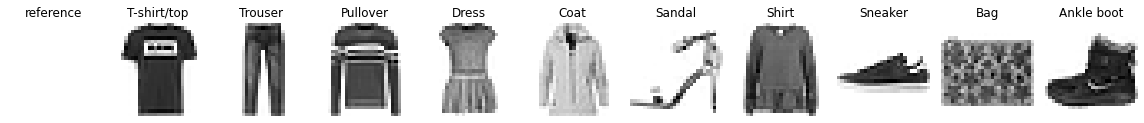

In [ ]:
# Name each one of the classes
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# Save an example for each category in a dict
images_dict = dict()
for i, l in enumerate(y_train):
  if len(images_dict)==10:
    break
  if l not in images_dict.keys():
    images_dict[l] = x_train[i].reshape((28, 28))

# Function to plot images
def plot_categories(images):
  fig, axes = plt.subplots(1, 11, figsize=(16, 15))
  axes = axes.flatten()
  
  # Plot an empty canvas
  ax = axes[0]
  dummy_array = np.array([[[0, 0, 0, 0]]], dtype='uint8')
  ax.set_title("reference")
  ax.set_axis_off()
  ax.imshow(dummy_array, interpolation='nearest')

  # Plot an image for every category
  for k,v in images.items():
    ax = axes[k+1]
    ax.imshow(v, cmap=plt.cm.binary)
    ax.set_title(f"{class_names[k]}")
    ax.set_axis_off()

  plt.tight_layout()
  plt.show()


# Use the function to plot
plot_categories(images_dict)

Now we know how the items in each one of the categories looks like.

We might wonder what the empty image at the left is for. We will see shortly why it is important.

## DeepExplainer

To compute shap values for the model we just trained we will use the `DeepExplainer` class from the `shap` library. 

To instantiate this class we need to pass in a model along with training examples. Notice that not all of the training examples are passed in but only a fraction of them. 

This is done because the computations done by the `DeepExplainer` object are very intensive on the RAM and we might run out of it.

In [ ]:
# Take a random sample of 5000 training images
background = x_train[np.random.choice(x_train.shape[0], 5000, replace=False)]

# Use DeepExplainer to explain predictions of the model
e = shap.DeepExplainer(model, background)

# Compute shap values
# shap_values = e.shap_values(x_test[1:5])

Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.


Now we can use the `DeepExplainer` instance to compute Shap values for images on the test set.

So we can properly visualize these values for each class, create an array that contains one element of each class from the test set:

In [ ]:
# Save an example of each class from the test set
x_test_dict = dict()
for i, l in enumerate(y_test):
  if len(x_test_dict)==10:
    break
  if l not in x_test_dict.keys():
    x_test_dict[l] = x_test[i]

# Convert to list preserving order of classes
x_test_each_class = [x_test_dict[i] for i in sorted(x_test_dict)]

# Convert to tensor
x_test_each_class = np.asarray(x_test_each_class)

# Print shape of tensor
print(f"x_test_each_class tensor has shape: {x_test_each_class.shape}")

x_test_each_class tensor has shape: (10, 28, 28, 1)


Before computing the shap values, make sure that the model is able to correctly classify each one of the examples we just picked:

In [ ]:
# Compute predictions
predictions = model.predict(x_test_each_class)

# Apply argmax to get predicted class
np.argmax(predictions, axis=1)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

Since the test examples are ordered according to the class number and the predictions array is also ordered, the model was able to correctly classify each one of these images.

In [ ]:
import shap
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

## Visualizing Shap Values

Now that we have an example of each class, compute the Shap values for each example:

In [ ]:
# Compute shap values using DeepExplainer instance
shap_values = e.shap_values(x_test_each_class)

`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


Now let's take a look at the computed shap values. To understand the next illustration have these points in mind:
- Positive shap values are denoted by red color and they represent the pixels that contributed to classifying that image as that particular class.
- Negative shap values are denoted by blue color and they represent the pixels that contributed to NOT classify that image as that particular class.
- Each row contains each one of the test images we computed the shap values for.
- Each column represents the ordered categories that the model could choose from. Notice that `shap.image_plot` just makes a copy of the classified image, but we can use the `plot_categories` function we created earlier to show an example of that class for reference.

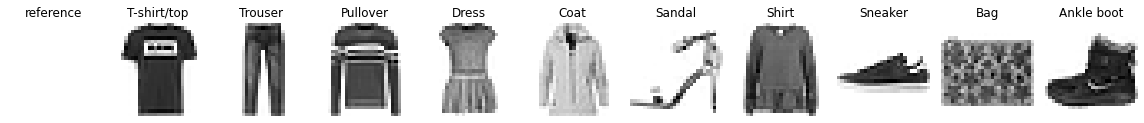

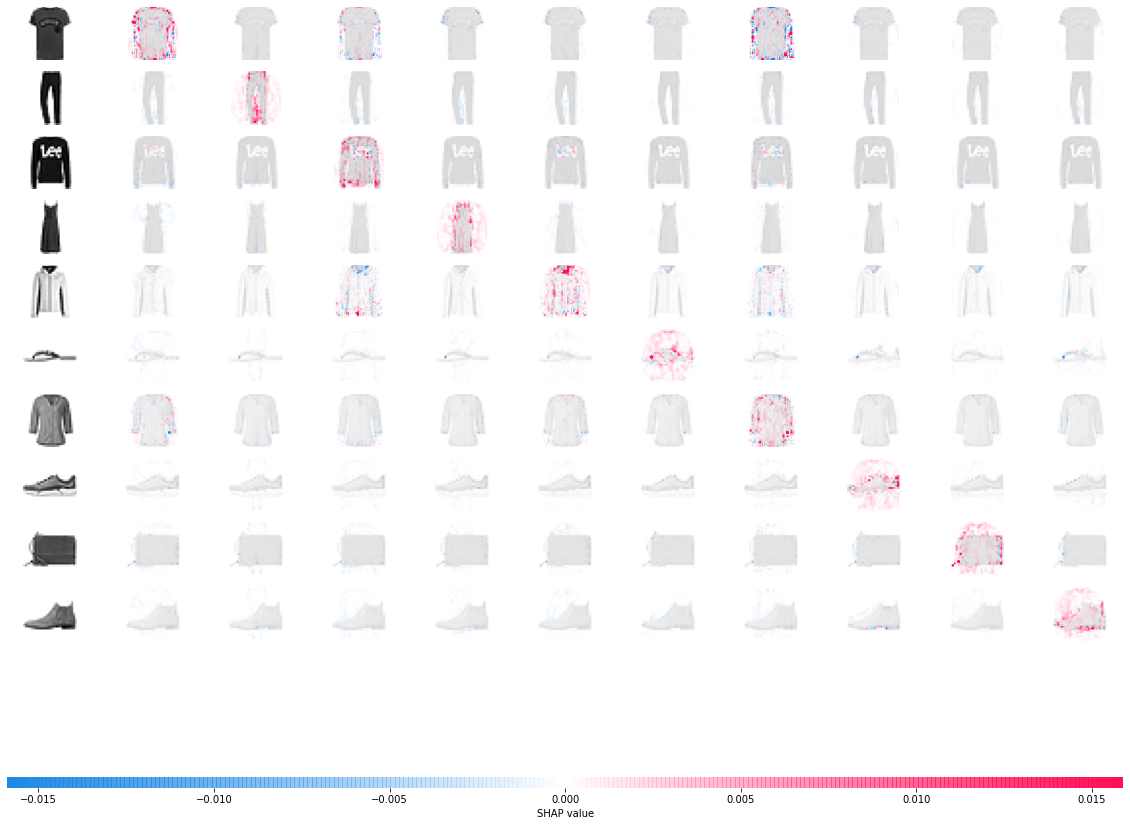

In [ ]:
# Plot reference column
plot_categories(images_dict)

# Print an empty line to separate the two plots
print()

# Plot shap values
shap.image_plot(shap_values, -x_test_each_class)

Now let's take some time to understand what the plot is showing us. Since the model is able to correctly classify each one of these 10 images, it makes sense that the shapley values along the diagonal are the most prevalent. Specially positive values since that is the class the model (correctly) predicted.


What else can we derive from this plot? Try focusing on one example. For instance focus on the **coat** which is the fifth class. Looks like the model also had "reasons" to classify it as **pullover** or a **shirt**. This can be concluded from the presence of positive shap values for these clases.

Let's take a look at the tensor of predictions to double check if this was the case:

In [ ]:
# Save the probability of belonging to each class for the fifth element of the set
coat_probs = predictions[4]

# Order the probabilities in ascending order
coat_args = np.argsort(coat_probs)

# Reverse the list and get the top 3 probabilities
top_coat_args = coat_args[::-1][:3]

# Print (ordered) top 3 classes
for i in list(top_coat_args):
  print(class_names[i])

Coat
Pullover
Shirt


Indeed the model selected these 3 classes as the most probable ones for the **coat** image. This makes sense since these objects are similar to each other.


Now look at the **t-shirt** which is the first class. This object is very similar to the **pullover** but without the long sleeves. It is not a surprise that white pixels in the area where the long sleeves are present will yield high shap values for classifying as a **t-shirt**. In the same way, white pixels in this area will yield negative shap values for classifying as a **pullover** since the model will expect these pixels to be colored if the item was indeed a **pullover**.


We can get a lot of insight repeating this process for all the classes.

## More on Explicability and Interpretability
To dive more deeply into TCAV and LIME

- Interpretability Beyond Feature Attribution: Quantitative Testing with Concept Activation Vectors (TCAV) [ICML 2018]. [arxiv:1711.11279](https://arxiv.org/abs/1711.11279); [pypi](https://pypi.org/project/tcav/).
- "Why Should I Trust You?": Explaining the Predictions of Any Classifier. [arxiv:1602.04938](https://arxiv.org/abs/1602.04938); [github](https://github.com/marcotcr/lime).


-----------------------------

